In [30]:
import math
import heapq
import matplotlib.pyplot as plt

class Polygon:
    def __init__(self, points=None):
        self.points = points if points else []
        self.hull = self.get_convex_hull()

    def add_point(self, point):
        self.points.append(point)
        self.hull = self.get_convex_hull()

    def remove_point(self, point):
        if point in self.points:
            self.points.remove(point)
            self.hull = self.get_convex_hull()

    def get_convex_hull(self):
        # Compute the convex hull using Graham's scan
        def orientation(p, q, r):
            return (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

        points = sorted(set(self.points))  # Remove duplicates and sort
        if len(points) <= 1:
            return points

        lower = []
        for p in points:
            while len(lower) >= 2 and orientation(lower[-2], lower[-1], p) <= 0:
                lower.pop()
            lower.append(p)

        upper = []
        for p in reversed(points):
            while len(upper) >= 2 and orientation(upper[-2], upper[-1], p) <= 0:
                upper.pop()
            upper.append(p)

        return lower[:-1] + upper[:-1]

    def plot_points_and_hull(self):
        plt.figure(figsize=(8, 6))

        # Plot all points
        x, y = zip(*self.points) if self.points else ([], [])
        plt.scatter(x, y, label="Points", color="blue", zorder=2)

        # Plot the convex hull
        if self.hull:
            hull_x, hull_y = zip(*(self.hull + [self.hull[0]]))  # Close the hull loop
            plt.plot(hull_x, hull_y, label="Convex Hull", color="red", zorder=1)

        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Convex Hull and Points")
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_intersection_points(self, segment_start, segment_end):
        """Returns a list of intersection points between the line segment and the polygon edges."""
        if not self.hull or len(self.hull) < 3:
            return []  # Not a valid polygon

        def line_intersection(p1, p2, p3, p4):
            """Calculates the intersection point between two line segments if it exists."""
            x1, y1 = p1
            x2, y2 = p2
            x3, y3 = p3
            x4, y4 = p4

            denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denominator == 0:
                return None  # Lines are parallel or coincident

            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

            # Check if the intersection point lies on both segments
            if (min(x1, x2) - 1e-8 <= px <= max(x1, x2) + 1e-8 and
                min(y1, y2) - 1e-8 <= py <= max(y1, y2) + 1e-8 and
                min(x3, x4) - 1e-8 <= px <= max(x3, x4) + 1e-8 and
                min(y3, y4) - 1e-8 <= py <= max(y3, y4) + 1e-8):
                return (px, py)
            else:
                return None

        intersection_points = []
        n = len(self.hull)
        for i in range(n):
            p1 = self.hull[i]
            p2 = self.hull[(i + 1) % n]

            intersect_point = line_intersection(p1, p2, segment_start, segment_end)
            if intersect_point is not None:
                intersection_points.append(intersect_point)

        return intersection_points

    def intersects_polygon(self, segment_start, segment_end):
        intersection_points = list(set(self.get_intersection_points(segment_start, segment_end)))
        if len(intersection_points) <= 1:
            return False
        if len(intersection_points) == 2:
            if self.no_edge_contains_both_points(intersection_points[0], intersection_points[1]):
                return True
            else:
                return False
        else:
            return True

    def no_edge_contains_both_points(self, point1, point2):
        """
        Returns True if there is no edge in the polygon that contains both point1 and point2.
        Returns False if both points lie on the same edge of the polygon.
        """
        if not self.hull or len(self.hull) < 2:
            return True  # Polygon has no edges to check

        for i in range(len(self.hull)):
            edge_start = self.hull[i]
            edge_end = self.hull[(i + 1) % len(self.hull)]

            # Check if both points lie on the current edge
            if self._point_on_edge(point1, edge_start, edge_end) and self._point_on_edge(point2, edge_start, edge_end):
                return False  # Both points lie on the same edge

        return True  # No edge contains both points

    def _point_on_edge(self, point, edge_start, edge_end):
        """
        Helper method to check if a point lies on a given edge (line segment).
        """
        x, y = point
        x1, y1 = edge_start
        x2, y2 = edge_end

        # Calculate the cross product to check colinearity
        cross = (y - y1) * (x2 - x1) - (x - x1) * (y2 - y1)
        if abs(cross) > 1e-8:
            return False  # Not colinear

        # Check if the point lies between the edge's endpoints
        dot_product = (x - x1) * (x2 - x1) + (y - y1) * (y2 - y1)
        if dot_product < 0:
            return False  # Point is before edge_start

        squared_length = (x2 - x1) ** 2 + (y2 - y1) ** 2
        if dot_product > squared_length:
            return False  # Point is after edge_end

        return True  # Point lies on the edge

    def contains_point(self, point):
        """Check if the point is inside the polygon using the ray casting method."""
        x, y = point
        num_vertices = len(self.hull)
        inside = False

        for i in range(num_vertices):
            xi, yi = self.hull[i]
            xj, yj = self.hull[(i + 1) % num_vertices]

            if ((yi > y) != (yj > y)) and \
               (x < (xj - xi) * (y - yi) / (yj - yi + 1e-12) + xi):
                inside = not inside

        return inside



In [59]:
import numpy as np
from copy import deepcopy
class Environment:
    def __init__(self, polygons=None, start=None, goal=None, robot=None):
        self.polygons = polygons if polygons else []
        self.original_polygons = deepcopy(polygons) if polygons else []
        self.extended_polygons = []
        self.start = start
        self.goal = goal
        self.robot = robot

        # Remove duplicates while preserving order
        points = self.get_points()
        seen = set()
        unique_points = []
        for point in points:
            if point not in seen:
                seen.add(point)
                unique_points.append(point)

        self.accessible_points = [self.start] + self.check_robot_vertices() + [self.goal]
        self.path_indices, self.distances = self.dijkstra_shortest_path()
        if self.path_indices:
            self.path_points = [self.accessible_points[i] for i in self.path_indices]
        else:
            self.path_points = [self.start, self.goal]

    def get_points(self):
        points = []
        for polygon in self.polygons:
            for point in polygon.points:
                accesible = True
                for polygon2 in self.polygons:
                    if polygon != polygon2 and polygon2.contains_point(point):
                        accesible = False
                if accesible:
                    points.append(point)
        return points
    
    def dist(self, point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
    def check_robot_vertices(self):
        # check if the robot polygon if shifted to one of the polygon vertices
        # if none of the edges of the robot intersect 
        # with the polygon edges then the robot is accessible
        robot_centroids = []
        polygons_extended = []
        for polygon in self.polygons:
            
            for poly_vertex in polygon.hull:
                for robot_vertex in self.robot.hull:
                    robot = deepcopy(self.robot)
                    robot_intersects = False
                    translated_bot = self.translate_polygon(robot, robot_vertex, poly_vertex)
                    robot_intersects = self.check_poly_intersects(translated_bot, polygon) + robot_intersects
                    if not robot_intersects:
                        robot_centroids.append(self.polygon_mean(translated_bot))
                        polygon.add_point(self.polygon_mean(translated_bot))
                    else:
                        polygon.add_point(self.polygon_mean(translated_bot))
            polygons_extended.append(polygon)
        self.extended_polygons = polygons_extended 
        return robot_centroids

    def polygon_mean(self, polygon):
        # calculate the mean of the polygon vertices
        x = 0.0
        y = 0.0
        for point in polygon.hull:
            x += point[0]
            y += point[1]
        return (x/len(polygon.hull), y/len(polygon.hull))
    
    def translate_polygon(self, polygon, point_polygon, point):
        # translate point_polygon to point and shift all the points with the same vector
        vector = (point[0] - point_polygon[0], point[1] - point_polygon[1])
        new_points = []
        for p in polygon.hull:
            new_points.append((p[0] + vector[0], p[1] + vector[1]))
        polygon.hull = new_points
        polygon.points = new_points
        return polygon

    def check_poly_intersects(self, poly1, poly2):
        # check if the two polygons intersect by iterating over all the edges of the two polygons
        if self.calculate_area_of_intersection(poly1, poly2) > 1e-4:
            return True
        else:
            return False
    
    def calculate_area_of_intersection(self, polygon1, polygon2):
        def shoelace_area(points):
            """Calculate the area of a polygon using the Shoelace formula."""
            n = len(points)
            if n < 3:  # Not a polygon
                return 0
            area = 0
            for i in range(n):
                x1, y1 = points[i]
                x2, y2 = points[(i + 1) % n]
                area += x1 * y2 - y1 * x2
            return abs(area) / 2

        # Step 1: Find all intersection points between the two polygons
        intersection_points = []
        for i in range(len(polygon1.hull)):
            p1_start = polygon1.hull[i]
            p1_end = polygon1.hull[(i + 1) % len(polygon1.hull)]
            intersection_points.extend(polygon2.get_intersection_points(p1_start, p1_end))

        # Step 2: Include vertices of polygon1 inside polygon2 and vice versa
        for point in polygon1.hull:
            if polygon2.contains_point(point):
                intersection_points.append(point)

        for point in polygon2.hull:
            if polygon1.contains_point(point):
                intersection_points.append(point)

        # Step 3: Remove duplicates and sort points to form a convex polygon
        intersection_points = list(set(intersection_points))  # Remove duplicates
        intersection_points = Polygon(intersection_points).hull  # Convex hull of intersection points

        # Step 4: Calculate the area of the intersection polygon
        return shoelace_area(intersection_points)
        

    
    def adjacency_matrix(self):
        n = len(self.accessible_points)
        # adjacency matrix is a np matrix of size n x n initialized with infinity
        adj_matrix = [[math.inf for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if i == j:
                    adj_matrix[i][j] = 0
                else:
                    path_intersectes_poly = False
                    for polygon in self.extended_polygons:
                        if polygon.intersects_polygon(self.accessible_points[i], self.accessible_points[j]):
                            path_intersectes_poly = True
                    if not path_intersectes_poly:
                        adj_matrix[i][j] = self.dist(self.accessible_points[i], self.accessible_points[j])
        return np.array(adj_matrix)
    
    def dijkstra_shortest_path(self):
        """
        Finds the shortest path from the start node (index 0) to the goal node (index -1)
        using Dijkstra's algorithm.

        Parameters:
        - A: 2D list or numpy array representing the adjacency matrix of the graph.

        Returns:
        - path: List of node indices representing the shortest path from start to goal.
                Returns None if no path exists.
        - distances: List of distances from the start node to each node.
        """
        A = self.adjacency_matrix()
        n = len(A)
        start = 0
        goal = n - 1

        # Initialize distances and predecessor lists
        distances = [float('inf')] * n
        distances[start] = 0
        predecessors = [None] * n

        # Priority queue to select the node with the smallest distance
        heap = [(0, start)]

        while heap:
            current_distance, current_node = heapq.heappop(heap)

            # If we reached the goal node, break
            if current_node == goal:
                break

            # Check all adjacent nodes
            for neighbor in range(n):
                edge_weight = A[current_node][neighbor]
                if edge_weight != float('inf') and edge_weight > 0:
                    distance = current_distance + edge_weight
                    if distance < distances[neighbor]:
                        distances[neighbor] = distance
                        predecessors[neighbor] = current_node
                        heapq.heappush(heap, (distance, neighbor))

        # Reconstruct the shortest path
        path = []
        current = goal
        if distances[goal] == float('inf'):
            print("No path exists from start to goal.")
            return None, distances

        while current is not None:
            path.insert(0, current)
            current = predecessors[current]

        return path, distances
    
    def plot_environment(self):
        # plot the start point end point and the polygons
        # plot the shortest path
        # shade the area that is not accessible

        plt.figure(figsize=(8, 6))

        # Plot the polygons
        for polygon in self.polygons:
            x, y = zip(*polygon.hull + [polygon.hull[0]])
            plt.plot(x, y, color="black", zorder=1)
        
        # Plot the start and goal points
        plt.scatter(*self.start, color="green", label="Start", zorder=3)
        plt.scatter(*self.goal, color="red", label="Goal", zorder=3)

        # Plot the shortest path
        if self.path_points:
            x, y = zip(*self.path_points)
            plt.plot(x, y, color="blue", label="Shortest Path", zorder=2)
        
        # shade polygons
        for polygon in self.polygons:
            x, y = zip(*polygon.hull + [polygon.hull[0]])
            plt.fill(x, y, color="gray", alpha=0.2, zorder=0)
        
        # shade polygons
        for polygon in self.original_polygons:
            x, y = zip(*polygon.hull + [polygon.hull[0]])
            plt.fill(x, y, color="red", alpha=0.8, zorder=0)
        
        # # plot the graph
        # for i in range(len(self.accessible_points)):
        #     for j in range(len(self.accessible_points)):
        #         if self.adjacency_matrix()[i][j] != math.inf:
        #             plt.plot([self.accessible_points[i][0], self.accessible_points[j][0]], [self.accessible_points[i][1], self.accessible_points[j][1]], color="black", zorder=0)

        # plot the robot
    
        x, y = zip(*self.robot.hull + [self.robot.hull[0]])
        plt.plot(x, y, color="black", zorder=1)

        # plot all the accepssible points
        x, y = zip(*self.accessible_points)
        plt.scatter(x, y, color="blue", label="Accessible Points", zorder=3)
        

        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Environment")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        

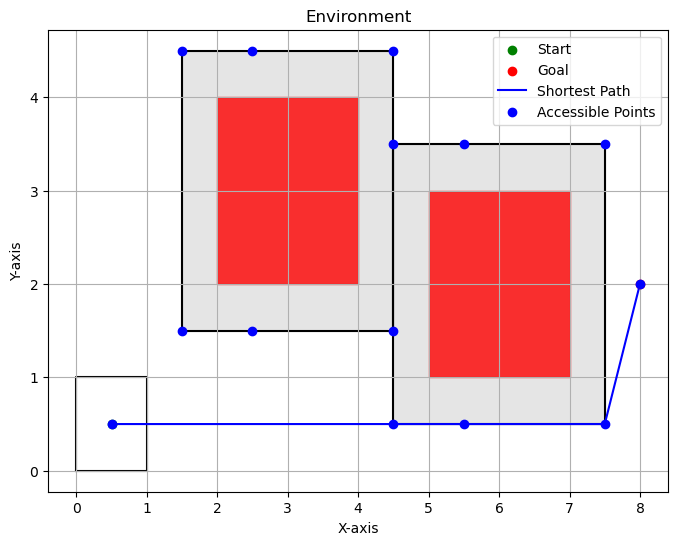

In [60]:

# Define polygons using the provided Polygon class
polygon1 = Polygon([(2, 2), (4, 2), (4, 4), (2, 4)])
polygon2 = Polygon([(5, 1), (7, 1), (7, 3), (5, 3)])
polygons = [polygon1, polygon2]

# Start and goal positions
start = (0.5, 0.5)
goal = (8, 2)

robot = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])

env = Environment(polygons, start, goal, robot)
env.plot_environment()
